In [ ]:
import os
import pandas as pd


folder_path = os.path.join("multilayer_logs", "dyn_dt_sweep_0.055_baraffwitkin")
# Create a list to store file info
file_info = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path) as f:
                row_count = sum(1 for _ in f) - 1  # subtract 1 for header
            file_info.append({"filename": filename, "row_count": row_count})
        except Exception as e:
            file_info.append({"filename": filename, "row_count": f"Error: {e}"})



row_counts_df = pd.DataFrame(file_info)

row_counts_df


,filename,row_count
0,avg-sigma.csv,553
1,fillin-pass.csv,2274
2,pcg-resid.csv,2274
3,line-search.csv,2274
4,max-search-dir.csv,2274
5,dyn-consumed.csv,2274
6,toi-recale.csv,2274
7,initialize.csv,1
8,dt.csv,553
9,num-contact.csv,2274


In [ ]:

# around row 641 for csvs with 1107 rows is when dt might have changed 

df = pd.read_csv("logs_archive/run_20250505_030057/newton-steps.csv")
df['time'] = df['time_or_frame'].copy()
df['newton_steps'] = df['value'].copy()

# calculate the difference between consecutive vid_time values
df['vid_time_diff'] = df['time'].diff()

# find the first index where the increment is (roughly) 0.02
threshold = 0.015  # in case it's slightly off from 0.02 due to float rounding
switch_row = df[df['vid_time_diff'] > threshold].index[0]

# show the row and maybe a few before/after for context
df.iloc[switch_row - 2 : switch_row + 3]
df


,time_or_frame,value,time,newton_steps,vid_time_diff
0,0.000000,3,0.000000,3,NaN
1,0.000227,2,0.000227,2,0.000227
2,0.000507,1,0.000507,1,0.000280
3,0.000694,2,0.000694,2,0.000187
4,0.000883,3,0.000883,3,0.000189
...,...,...,...,...,...
1102,3.968071,1,3.968071,1,0.019976
1103,3.975487,1,3.975487,1,0.007416
1104,3.983251,1,3.983251,1,0.007764
1105,3.990983,1,3.990983,1,0.007732


In [ ]:
# this successfully maps frames to newton steps!!!!



newton_df = pd.read_csv("logs_archive/run_20250505_030057/newton-steps.csv")
frame_df = pd.read_csv("logs_archive/run_20250505_030057/frame-to-time.csv")
newton_df['time'] = newton_df['time_or_frame'].copy()
newton_df['newton_steps'] = newton_df['value'].copy()
newton_df = newton_df[['time','newton_steps']]

frame_df['frame'] = frame_df['time_or_frame'].copy()
frame_df['time']=frame_df['value'].copy()
frame_df = frame_df[['frame','time']]
frame_df = frame_df.sort_values("time").reset_index(drop=True)


# Merge on the closest matching time using merge_asof
frame_df_sorted = frame_df.sort_values("time")
newton_df_sorted = newton_df.sort_values("time")

# Map time to closest frame time
merged_df = pd.merge_asof(newton_df_sorted, frame_df_sorted, on="time", direction='backward')

# Rename for clarity
merged_df = merged_df.rename(columns={"frame": "corresponding_frame"})

# Optional: see the result
merged_df.head()

pcg = pd.read_csv("logs_archive/run_20250505_030057/pcg-iter.csv")

pcg['time'] = pcg['time_or_frame'].copy()
pcg['iterations'] = pcg['value'].copy()
pcg = pcg[['time','iterations']]
# Map time to closest frame time
merged_df2 = pd.merge_asof(pcg, merged_df, on="time", direction='backward')
# Rename for clarity
merged_df2 = merged_df2.rename(columns={"frame": "corresponding_frame"})
# Optional: see the result
merged_df2.head()


,time,newton_steps,corresponding_frame
0,0.000000,3,0
1,0.000227,2,0
2,0.000507,1,0
3,0.000694,2,0
4,0.000883,3,0


In [ ]:
pcg = pd.read_csv("logs_archive/run_20250505_030057/pcg-iter.csv")

pcg['time'] = pcg['time_or_frame'].copy()
pcg['iterations'] = pcg['value'].copy()
pcg = pcg[['time','iterations']]
# Map time to closest frame time
merged_df2 = pd.merge_asof(pcg, merged_df, on="time", direction='backward')
# Rename for clarity
merged_df2 = merged_df2.rename(columns={"frame": "corresponding_frame"})
# Optional: see the result
merged_df2.head()

,time,iterations,newton_steps,corresponding_frame
0,0.000000,262,3,0
1,0.000000,325,3,0
2,0.000000,331,3,0
3,0.000000,166,3,0
4,0.000227,331,2,0


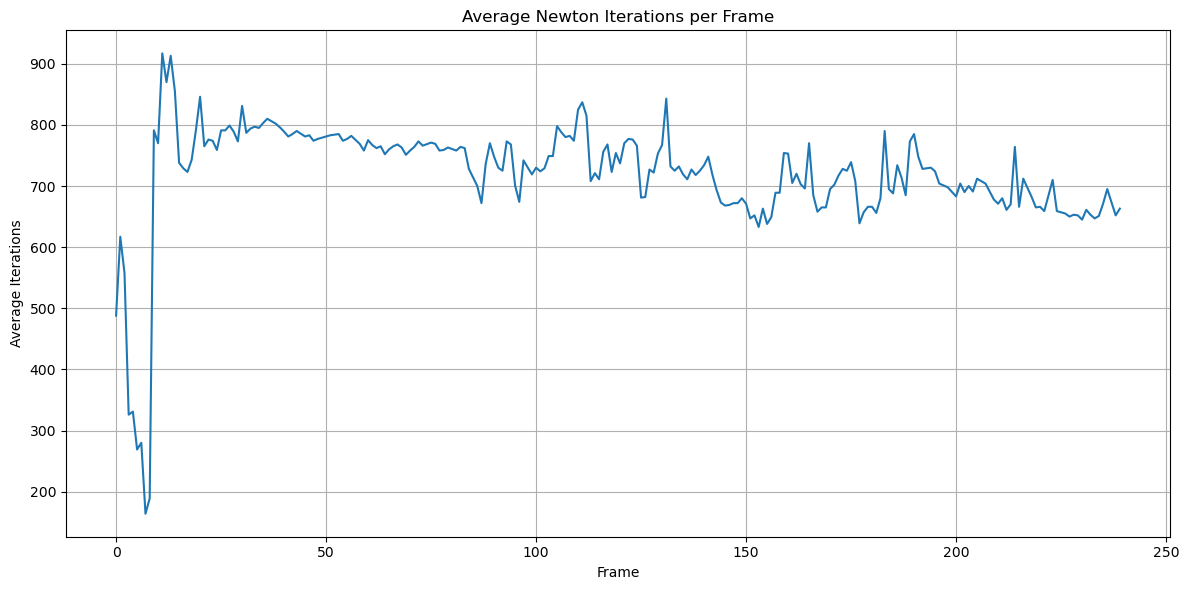

In [15]:
import matplotlib.pyplot as plt

# Group by 'corresponding_frame' and calculate average iterations
avg_iterations_per_frame = merged_df2.groupby('corresponding_frame')['iterations'].max().reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_iterations_per_frame['corresponding_frame'], avg_iterations_per_frame['iterations'])
plt.title('Average Newton Iterations per Frame')
plt.xlabel('Frame')
plt.ylabel('Average Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import os
import pandas as pd
import glob


def merge_logs(folder_path):
    """
    Merges newton-steps.csv, frame-to-time.csv, and pcg-iter.csv from a given log folder.
    Returns a DataFrame with time, newton_steps, iterations, and corresponding_frame.
    """
    # Load and preprocess newton-steps
    newton_df = pd.read_csv(os.path.join(folder_path, "newton-steps.csv"))
    newton_df['time'] = newton_df['frame']
    newton_df['newton_steps'] = newton_df['value']
    newton_df = newton_df[['time', 'newton_steps']].sort_values('time')

    # Load and preprocess frame-to-time
    frame_df = pd.read_csv(os.path.join(folder_path, "frame-to-time.csv"))
    # frame_df['frame'] = frame_df['time_or_frame']
    frame_df['time'] = frame_df['value']
    frame_df = frame_df[['frame', 'time']].sort_values('time').reset_index(drop=True)

    # Merge newton steps to frame
    merged_df = pd.merge_asof(newton_df, frame_df, on="time", direction='backward')
    merged_df = merged_df.rename(columns={"frame": "corresponding_frame"})

    # Load and preprocess pcg-iter
    pcg_df = pd.read_csv(os.path.join(folder_path, "pcg-iter.csv"))
    pcg_df['time'] = pcg_df['frame']
    pcg_df['iterations'] = pcg_df['value']
    pcg_df = pcg_df[['time', 'iterations']].sort_values('time')

    num_contact = pd.read_csv(os.path.join(folder_path, "num-contact.csv"))
    num_contact['time'] = num_contact['frame']
    num_contact['num_contact'] = num_contact['value']
    num_contact = num_contact[['time', 'num_contact']].sort_values('time')
    # Merge num_contact data
    merged_df = pd.merge_asof(merged_df, num_contact, on="time", direction='backward')

    # Merge pcg data
    final_df = pd.merge_asof(pcg_df, merged_df, on="time", direction='backward')

    return final_df


def read_params_txt(folder_path):
    """Reads params.txt from a folder and returns a dictionary of its values."""
    param_file = os.path.join(folder_path, "params.txt")
    params = {}
    try:
        with open(param_file, "r") as f:
            for line in f:
                if ':' in line:
                    key, value = line.strip().split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    # Try converting value to float if possible
                    try:
                        value = float(value)
                    except ValueError:
                        pass
                    params[key] = value
    except FileNotFoundError:
        print(f"No params.txt found in {folder_path}")
    return params

all_dfs = []

# Iterate over all folders inside high_iter
for path in glob.glob("fabric_logs/*"):
    if os.path.isdir(path):
        try:
            df = merge_logs(path)
            df['source_folder'] = os.path.basename(path)

            # Parse params and attach as new columns
            params = read_params_txt(path)
            for key, val in params.items():
                df[key] = val  # broadcast param value to entire DataFrame

            all_dfs.append(df)
        except Exception as e:
            print(f"Failed to process {path}: {e}")


In [17]:
all_combined_df = pd.concat(all_dfs, ignore_index=True)

# all_combined_df.to_csv("all_logs_combined.csv", index=False)
#
all_combined_df

,time,iterations,newton_steps,corresponding_frame,num_contact,source_folder,name,dt,dyn_dt_change,strain-limit-eps,bend,area-density,contact-ghat,friction
0,0.000000,524,3,0,0,fabric_silk_3,silk_3,0.003,0.045,0.1,1.0,1000.0,0.0004,0.02
1,0.000000,805,3,0,0,fabric_silk_3,silk_3,0.003,0.045,0.1,1.0,1000.0,0.0004,0.02
2,0.000000,805,3,0,0,fabric_silk_3,silk_3,0.003,0.045,0.1,1.0,1000.0,0.0004,0.02
3,0.000000,473,3,0,0,fabric_silk_3,silk_3,0.003,0.045,0.1,1.0,1000.0,0.0004,0.02
4,0.001049,927,1,0,0,fabric_silk_3,silk_3,0.003,0.045,0.1,1.0,1000.0,0.0004,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81095,3.863638,1558,1,231,13149,fabric_silk_0.052,silk_0.052,0.003,0.052,0.1,1.0,1000.0,0.0004,0.02
81096,3.909173,1505,1,234,13146,fabric_silk_0.052,silk_0.052,0.003,0.052,0.1,1.0,1000.0,0.0004,0.02
81097,3.909173,1589,1,234,13146,fabric_silk_0.052,silk_0.052,0.003,0.052,0.1,1.0,1000.0,0.0004,0.02
81098,3.957108,1511,1,237,13125,fabric_silk_0.052,silk_0.052,0.003,0.052,0.1,1.0,1000.0,0.0004,0.02


In [20]:
#df just for silk
silk_df = all_combined_df[all_combined_df['source_folder'].str.contains("silk")]

#df just for chiffon
chiffon_df = all_combined_df[all_combined_df['source_folder'].str.contains("chiffon")]
chiffon_df

,time,iterations,newton_steps,corresponding_frame,num_contact,source_folder,name,dt,dyn_dt_change,strain-limit-eps,bend,area-density,contact-ghat,friction
26306,0.000000,452,3,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
26307,0.000000,1053,3,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
26308,0.000000,1070,3,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
26309,0.000000,611,3,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
26310,0.001082,1182,2,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68383,3.945853,2787,2,236,14011,fabric_chiffon_2,chiffon_2,0.003,0.040,0.15,0.5,500.0,0.0003,0.005
68384,3.945853,2816,2,236,14011,fabric_chiffon_2,chiffon_2,0.003,0.040,0.15,0.5,500.0,0.0003,0.005
68385,3.945853,2654,2,236,14011,fabric_chiffon_2,chiffon_2,0.003,0.040,0.15,0.5,500.0,0.0003,0.005
68386,3.985853,2839,1,236,14024,fabric_chiffon_2,chiffon_2,0.003,0.040,0.15,0.5,500.0,0.0003,0.005


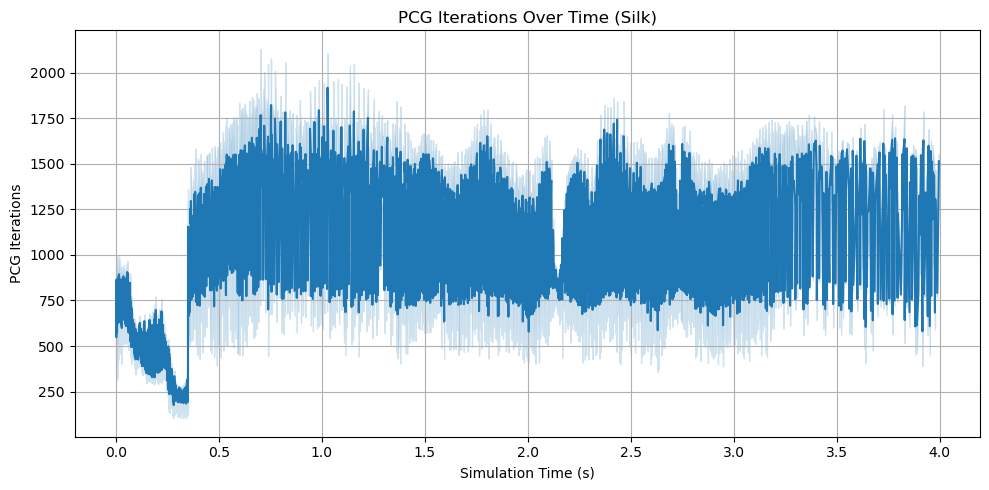

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your merged DataFrame (replace with your actual path or object)
# df = pd.read_csv("your_merged_log.csv")  
# df = all_combined_df.copy()
df = silk_df.copy()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="time", y="iterations")
plt.title("PCG Iterations Over Time (Silk)")
plt.xlabel("Simulation Time (s)")
plt.ylabel("PCG Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()


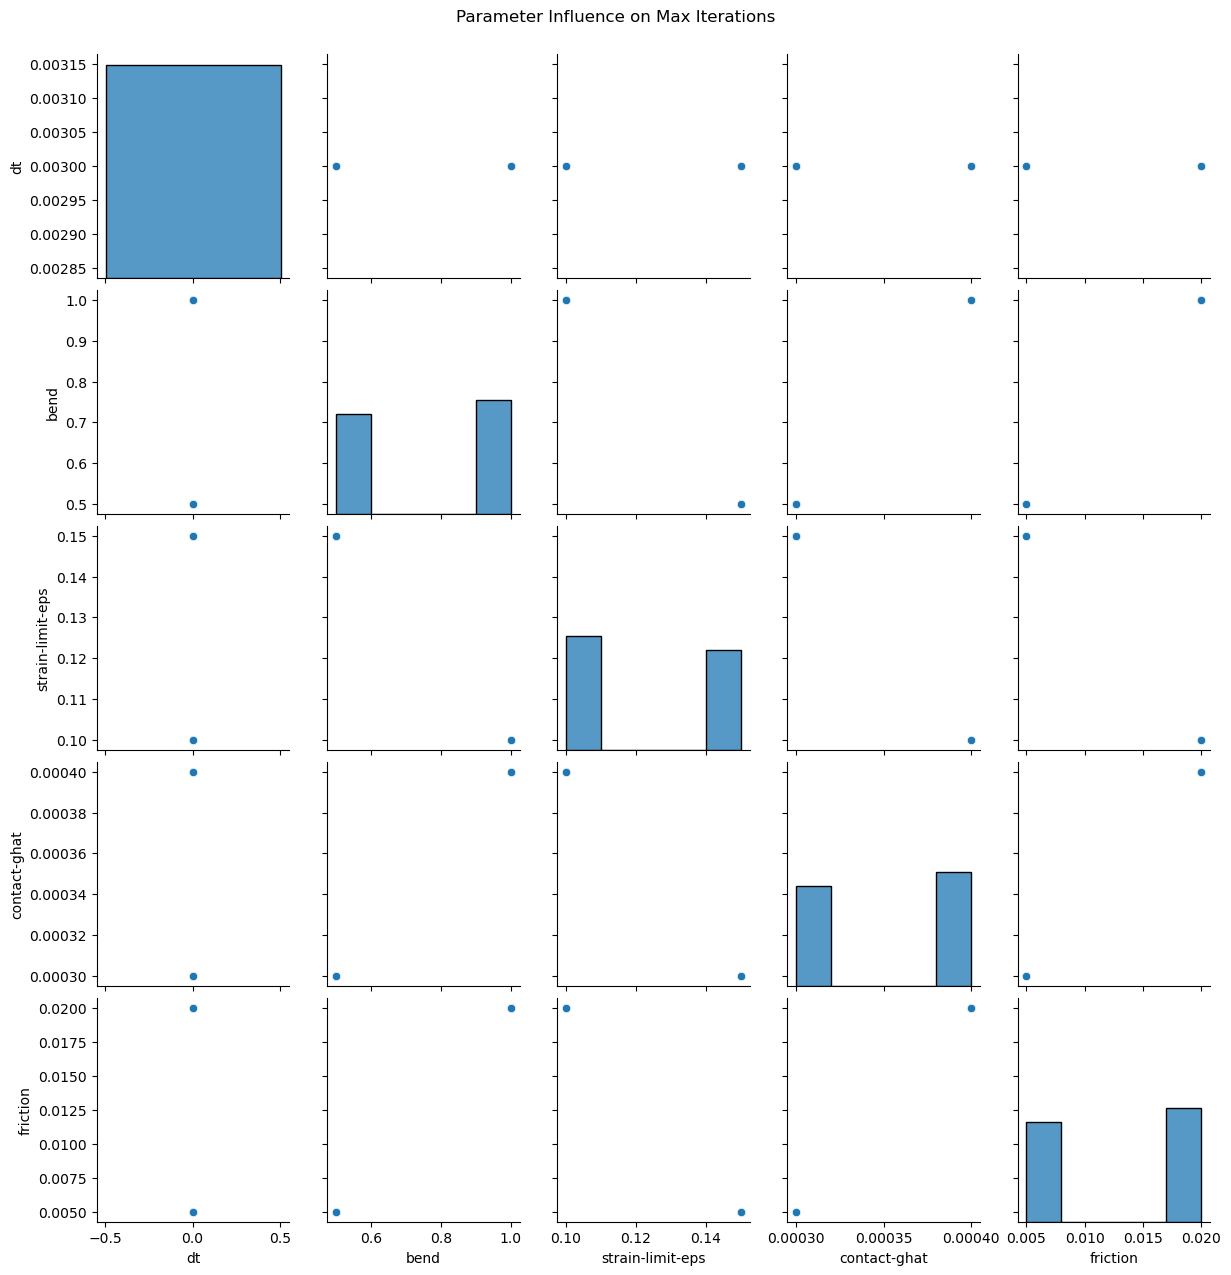

In [ ]:
# Get one row per run with max iterations and its associated params
run_summary = pd.DataFrame()
for df in all_dfs:
    summary = df[['iterations']].max().to_frame().T
    summary['source_folder'] = df['source_folder'].iloc[0]

    # Include all parameter columns
    param_cols = [col for col in df.columns if col not in ['time', 'newton_steps', 'iterations', 'corresponding_frame', 'source_folder']]
    for col in param_cols:
        summary[col] = df[col].iloc[0]
    
    run_summary = pd.concat([run_summary, summary], ignore_index=True)

run_summary.head()

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(run_summary, vars=['dt', 'bend', 'strain-limit-eps', 'contact-ghat', 'friction'], 
             y_vars=['iterations'], height=2.5)
plt.suptitle("Parameter Influence on Max Iterations", y=1.02)
plt.show()



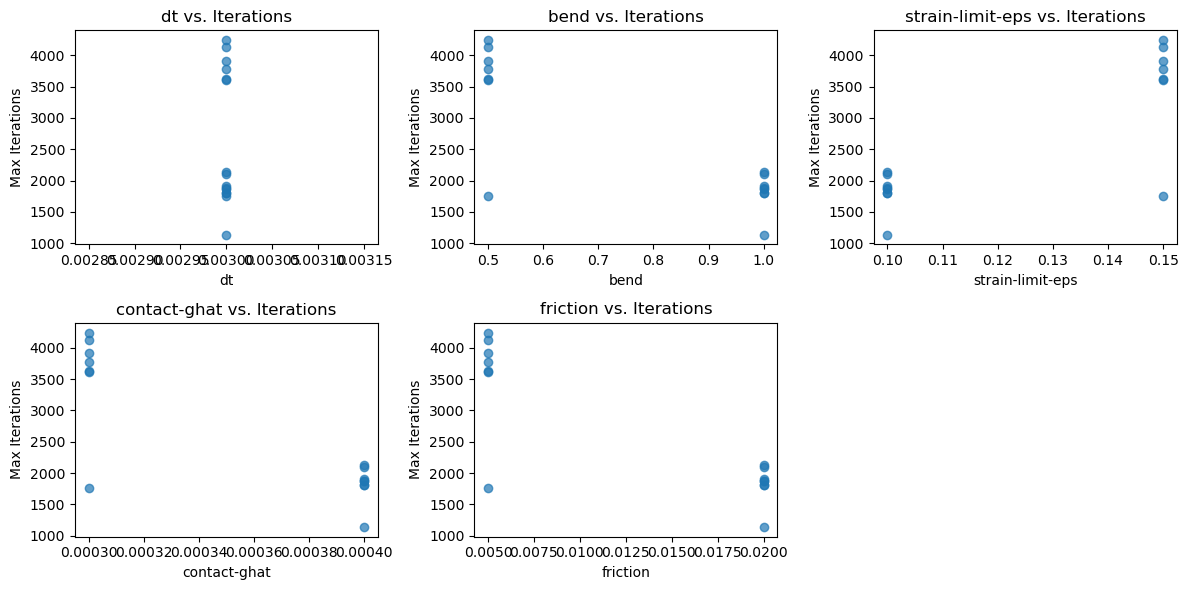

In [14]:
plt.figure(figsize=(12, 6))

for i, param in enumerate(['dt', 'bend', 'strain-limit-eps', 'contact-ghat', 'friction'], 1):
    plt.subplot(2, 3, i)
    plt.scatter(run_summary[param], run_summary['iterations'], alpha=0.7)
    plt.xlabel(param)
    plt.ylabel('Max Iterations')
    plt.title(f'{param} vs. Iterations')

plt.tight_layout()
plt.show()


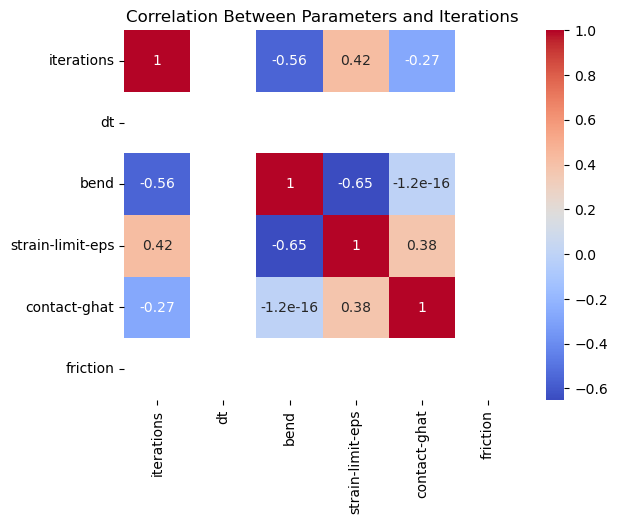

In [12]:
corr = run_summary[['iterations', 'dt', 'bend', 'strain-limit-eps', 'contact-ghat', 'friction']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Parameters and Iterations")
plt.show()


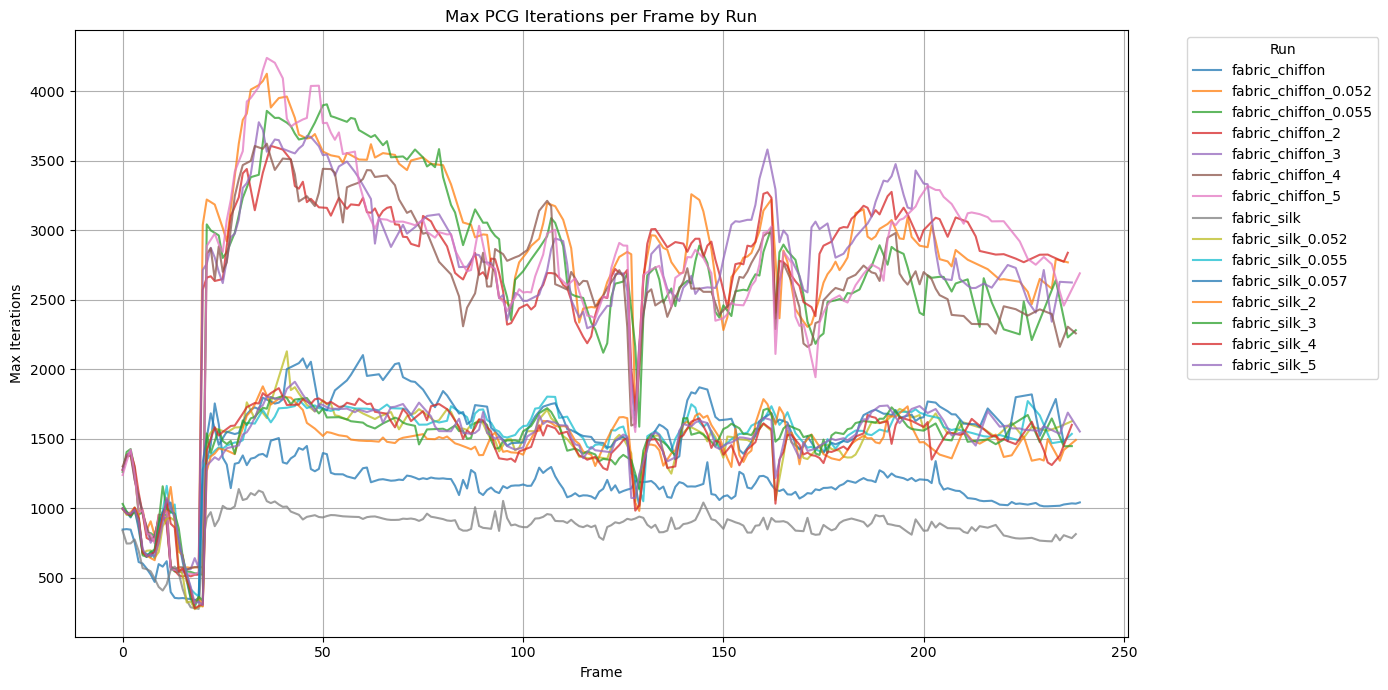

In [19]:
# Make sure the DataFrame includes a 'source_folder' column
grouped = all_combined_df.groupby(['source_folder', 'corresponding_frame'])['iterations'].max().reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot each run's max iterations per frame
for run_name in grouped['source_folder'].unique():
    run_data = grouped[grouped['source_folder'] == run_name]
    plt.plot(run_data['corresponding_frame'], run_data['iterations'], label=run_name, alpha=0.75)

plt.title("Max PCG Iterations per Frame by Run")
plt.xlabel("Frame")
plt.ylabel("Max Iterations")
plt.legend(title="Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



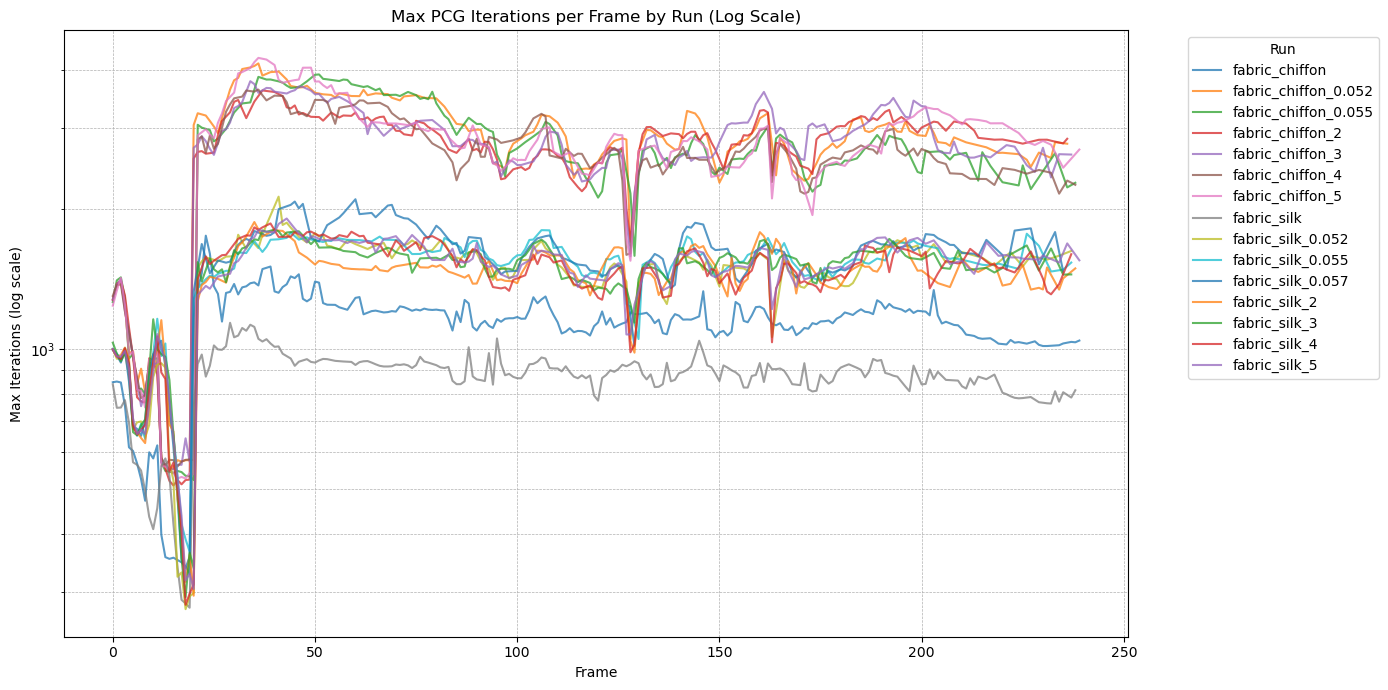

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for run_name in grouped['source_folder'].unique():
    run_data = grouped[grouped['source_folder'] == run_name]
    plt.plot(run_data['corresponding_frame'], run_data['iterations'], label=run_name, alpha=0.75)

plt.yscale('log')  # log scale
plt.title("Max PCG Iterations per Frame by Run (Log Scale)")
plt.xlabel("Frame")
plt.ylabel("Max Iterations (log scale)")
plt.legend(title="Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## TODO
I think i'm at a really place right now to play round with the simulation more. I read GPU_IPC's research paper and thier netwon methods are in the 1e4 range, which is way over mine. They included a chart that features the paramters they used, like time step size, density modulus, number of vertices, etc so next I want to mimic those paramters. Hopefully I don't come into any computation power problems with the solver. 
I want to compare how many vertices are in my cloth vs theirs, and increase cg-max-iter and maybe cg-tol, if necesarry. From there, I think I need to start over again with running and collecting data to process here, but I think i've streamlined the process enough for it to not be that bad. 

I think pcg tol should be 1e-4?????????



first:

test arap and baraffwitkin on normal ish params and compare

then whicheverer is more stable, start mimicing params from gipc slowly:
    - maybe 

v: interior for tetrahedral meshes (v)

t: number of tetrahedra
 
f:  number of surface triangles (f) 

Δt: time-step size in seconds

ρ: material density 
 
E: Young’s modulusin units of pascals Pa
 
υ: Poisson’s ratio 
  
ˆd: computational accuracy target in meters , which is set w.r.t. to the scene bounding box diagonal length l

ϵd: Newton Solver tolerance threshold 
 
μ: friction coefficient 
 
ϵv: velocity magnitude bound 
 
#Δt: Total number of time steps (#Δt)



Total time to build/find contact pairs (buildCP); Total time to build energy gradients and Hessians for all types (buildGH); Total linear solver time (solve); Total CCD time
(CCD); Average number of Newton iterations per time step (#i)

In [ ]:
def run_simulation(shell_model, label):
    param = (
        app.session.param()
        .set("fitting")
        .set("model-shell", shell_model)
        .set("dt", 0.05)
        .set("frames", 240)
        .set("friction", 0.8)
        .set("contact-ghat", 1e-4)
        .set("strain-limit-eps", 0.01)
        .set("output-folder", f"output_{label}")
    )

    scene = app.load("fitting", param)
    session = app.session.create(scene)
    session.run()
    session.report()
    return session

# Run both simulations
session_arap = run_simulation("arap", "arap")
session_bw = run_simulation("baraffwitkin", "bw")

import json
import csv
import os

def log_pcg_stats(session, label="simulation"):
    # Extract logs
    frame_to_time = session.get.log.numbers("frame-to-time")
    newton_steps = session.get.log.numbers("newton-steps")
    pcg_iterations = session.get.log.numbers("pcg-iter")

    # Prepare frame intervals
    frame_times = sorted(frame_to_time)
    frame_intervals = [
        (
            f,
            frame_times[i][1],
            frame_times[i + 1][1] if i + 1 < len(frame_times) else float("inf"),
        )
        for i, (f, _) in enumerate(frame_times)
    ]

    # Collect per-frame PCG/Newton stats
    data = []
    for frame_id, t_start, t_end in frame_intervals:
        newton_in_frame = [(t, n) for t, n in newton_steps if t_start <= t < t_end]
        pcg_in_frame = [n for t, n in pcg_iterations if t_start <= t < t_end]

        entry = {
            "frame": frame_id,
            "newton_steps": len(newton_in_frame),
            "total_pcg_iter": sum(pcg_in_frame),
            "avg_pcg_per_newton": sum(pcg_in_frame) / len(newton_in_frame) if newton_in_frame else 0
        }
        print(f"Frame {frame_id}: {entry['newton_steps']} Newton steps, "
              f"{entry['total_pcg_iter']} total PCG iter, "
              f"avg {entry['avg_pcg_per_newton']:.2f} per step")
        data.append(entry)

    # Save CSV
    csv_path = f"{label}_pcg_stats.csv"
    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)
    print(f"Saved PCG stats to {csv_path}")

    # Save parameters
    param_data = session.scene().param().dict()
    param_path = f"{label}_params.json"
    with open(param_path, "w") as f:
        json.dump(param_data, f, indent=2)
    print(f"Saved simulation parameters to {param_path}")

    log_pcg_stats(session_arap, "arap")
log_pcg_stats(session_bw, "bw")


param = (
    app.session.param()
    .set("fitting")
    .set("dt", 0.05)
    .set("frames", 240)
    .set("friction", 0.00)
    .set("model-shell", "baraffwitkin")
    .set("contact-ghat", 0.3e-3)
    .set("strain-limit-eps", 0.06)
    #.set("contact-ghat", 0.4e-3) # 0.5e3  parameter controls the activation threshold of contact. Lower values increase contact density:
    #.set("strain-limit-eps", 0.06) #0.1 Make it smaller to strongly limit how much the cloth can stretch
    .set("cg-tol", 1e-4)
    .set("cg-max-iter",500000)
   .set("bend",15)
    .set("area-density", 7000)
     .set("gravity", -11.98)


)
param = (
    app.session.param()
    .set("fitting")
    .set("dt", 0.015)
    .set("frames", 240)
    .set("friction", 0.02)
    .set("model-shell", "baraffwitkin")
    .set("contact-ghat", 0.6e-3)
    .set("strain-limit-eps", 0.2)
    #.set("contact-ghat", 0.4e-3) # 0.5e3  parameter controls the activation threshold of contact. Lower values increase contact density:
    #.set("strain-limit-eps", 0.06) #0.1 Make it smaller to strongly limit how much the cloth can stretch
    .set("cg-tol", 1e-5)
    .set("cg-max-iter",500000)
   .set("bend",20)
    .set("area-density", 3000)
     # .set("gravity", -11.98)
)
param.dyn("fitting").time(0.15).hold().change(False)
param.dyn("dt").time(0.15).hold().change(0.05) 



# this is for multilayer dress
param = (
    app.session.param()
    .set("fitting")
    .set("dt", 0.003)
    .set("frames", 240)
    .set("friction", 0.02)
    .set("model-shell", "baraffwitkin")
    .set("contact-ghat", 0.8e-3) # 0.5e3  parameter controls the activation threshold of contact. Lower values increase contact density:
    .set("strain-limit-eps", 0.2) #0.1 Make it smaller to strongly limit how much the cloth can stretch
    .set("cg-tol", 0.1e-5)
    .set("cg-max-iter",500000)
    .set("bend",25)
    .set("area-density", 10000)
)
param.dyn("fitting").time(0.35).hold().change(False)
param.dyn("dt").time(0.35).hold().change(0.04) 

In [ ]:
# strain sweeps were good. they made the dress fit a bit loseer 